# Projection-based model-order reduction for nonlinear heat conduction in 1D
Jean C. Ragusa

Texas A&M University

jean.ragusa@tamu.edu


# General Problem definition

Consider a 1D **nonlinear** heat conduction problem
$$ -\frac{d}{dx} k(x,T)\frac{dT}{dx} = q(x)
$$
where the conductivity is a function of temperature $$k(x,T)=k^0(x) + k^1(x)T$$
Hence, we are solving:
$$ -\frac{d}{dx} (k^0(x) + k^1(x) T)\frac{dT}{dx} = q(x)
$$
Boundary conditions:
- reflective at $x=0$: $\quad \left.\tfrac{dT}{dx}\right|_0 = 0$
- imposed temperature (Dirichlet bc) at $x=L$: $\quad T(L)=T_{bc}$

Linear version of the problem: set $k^1(x) = 0$

# Linear problem with zone-wise properties
Linear heat conduction
$$ -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) $$


| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 0.4]\end{equation} | 1.37142857  | 3500. |  
| II | \begin{equation}x \in [0.4, 0.5]\end{equation} | 2.          |   50. | 


### load python modules

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg
import time

# 1-D slab mesh and material properties
We give material properties "per zone" and then replicate them as many times as needed to assign them to a mesh cell (mesh resolution is a refinement of the material zone layout).

In [23]:
def create_slab_mesh(n_ref,dx_):
    # input: 
    #    n_ref: integer (how many times each zone is to be refined)
    #    dx_  : array of zone widths
    # output:
    #    x: array of cell interface positions
    #    dx: array of cell widths
    #    cell2mat: given a cell index, this returns the material ID in that cell
    
    # compute cell widths
    dx   = np.repeat(dx_  , n_ref) / float(n_ref)
    
    # cell interfaces
    x = np.zeros(len(dx)+1)
    for i in range(len(dx)):
        x[i+1] = x[i] + dx[i]
        
    # create cell2mat
    cell2mat = np.repeat( np.arange(len(dx_)), n_ref)
       
    return x, dx, cell2mat

cell interfaces= [0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


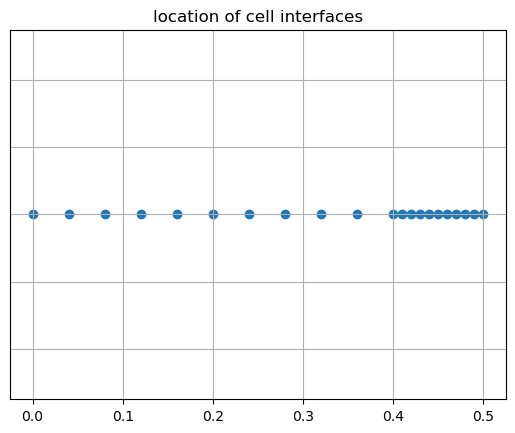

In [24]:
# small demo:
x, dx, cell2mat = create_slab_mesh(n_ref=10,dx_=np.array([0.4,0.1]))

print('cell interfaces=',x)
# plot
plt.figure()
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none') 
plt.scatter(x, np.zeros(len(x)))
plt.title('location of cell interfaces')
plt.grid()
plt.show()

# Linear portion of the problem: matrix
We write a **vertex-centered** simple finite difference for the **linear** term $-\frac{d}{dx}k^0\frac{dT}{dx} = q$

Or,
$$
-k^0_{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
k^0_{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$
where the full integer indices denote nodal (vertex) values and the half-integer indices denote cell values. $\Delta x_{i+1/2}=x_{i+1}-x_i$.

Finally, the last row simply encodes the Dirichlet boundary condition $A_{N,N} T_N=T_{Dirichlet}$ with $A_{N,N}=1$.
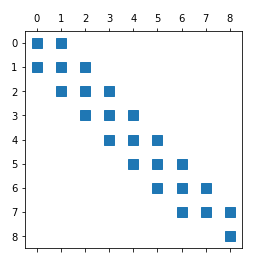

Resulting linear system:
$$ A T = b$$
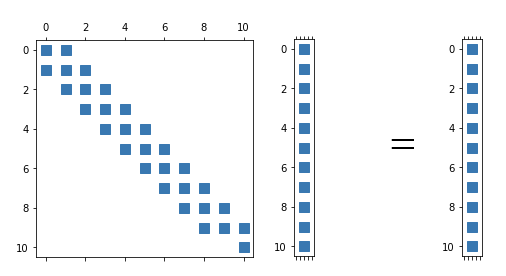

# Affine decomposition of the A matrix operator
Because the material property can be piece-wise constant per zone, the matrix $A$ representing $-\frac{d}{dx}k^0\frac{d}{dx}$
can be written as
$$
A(k^0) = \sum_{imat=1}^{Nmat} k^0_{imat} A_{imat} + A_{bc}
$$
where $A_{imat}$ corresponds to the portion of the matrix related to zone imat
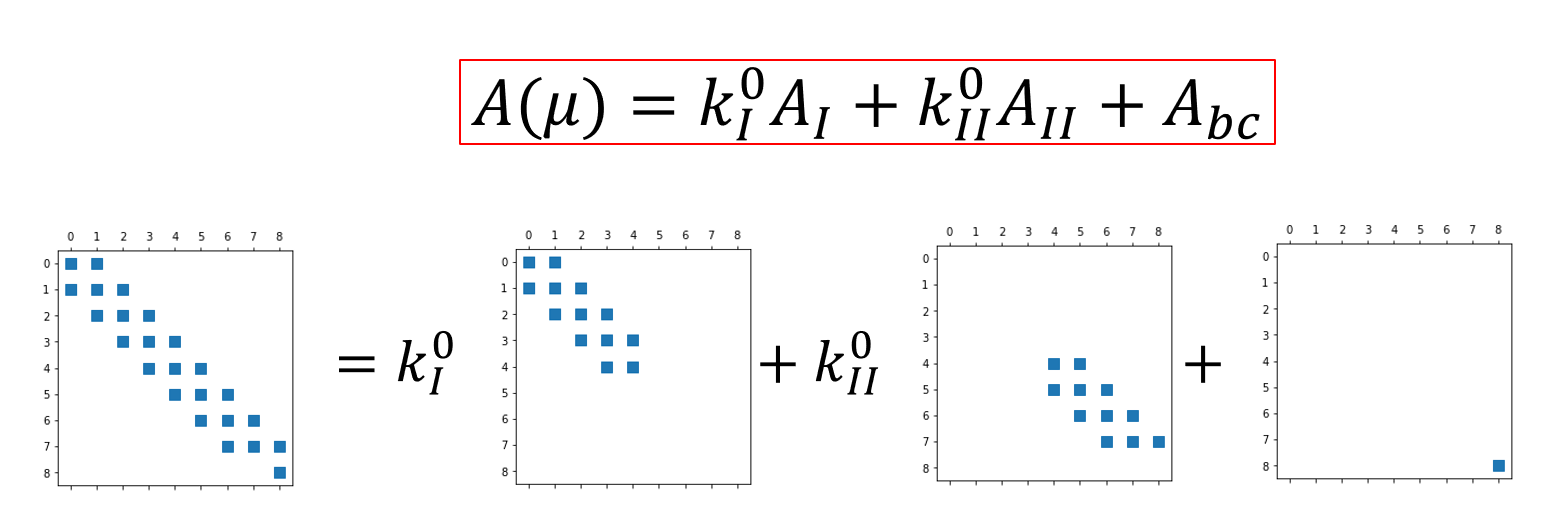

The routine below computes each of the $A_{imat}$ and $A_{bc}$ individually

In [25]:
def build_matrix_per_zone(cond_, dx, cell2mat):
    # input: 
    #    cond_: conductivity array (length = number of material zones)
    #    dx   : array of cell widths (length = number of cells)
    #    cell2mat: given a cell index, this returns the material ID in that cell
    # output:
    #    K_list: list of finite-difference matrices in sparse format, one per material zone
    #    K_bc: BC contribution to the final matrix

    # number of points
    n_pts = len(dx) + 1

    # create indices for rows and columns of the tridiagonal stiffness matrix
    indr = np.kron(np.arange(0,n_pts),np.ones(3))
    indr = indr[1:-1]

    indc = np.zeros((n_pts,3))
    indc[0,:] = np.array([-1,0,1],dtype=int)
    for i in range (1,n_pts):
        indc[i,:] = indc[i-1,:]+1
    indc = indc.flatten()
    indc = indc[1:-1]
    
    # matrix list
    K_list = []
    for imat in range(len(cond_)):
        # make unit material property per cell when cell contains material imat
        temp = np.zeros_like(cond_)
        temp[imat] = 1.
        cond = temp[cell2mat]
        # build matrix for zone imat
        L = np.zeros(n_pts)
        L[1:] = -cond/dx
        R = np.zeros(n_pts)
        R[:-1] = -cond/dx
        D = np.zeros(n_pts)
        D[:-1] += -R[:-1]
        D[1:]  += -L[1:]  
        arr = np.vstack((L,D,R)).T.flatten()[1:-1]
        K = sparse.csr_matrix( (arr, (indr, indc)), shape=(n_pts, n_pts) )
        # apply right bc (Dirichlet)
        K[-1,-2:]=0
        # save in list
        K_list.append(K)

    # create sparse bc matrix
    arr[:]  = 0.
    arr[-1] = 1.
    K_bc = sparse.csr_matrix( (arr, (indr, indc)), shape=(n_pts, n_pts) )

    return K_list, K_bc

#### This routine just performs the summation
$$
A(k^0) = \sum_{imat=1}^{Nmat} k^0_{imat} A_{imat} + A_{bc}
$$

In [26]:
def combine_matrix_per_zone(matprop_,K_list,K_bc):
    # input: 
    #    matprop_: material property array (length = number of material zones)
    #    K_list: list of finite-differnece matrices in sparse format, one per material zone
    #    K_bc: BC contribution to the final matrix
    # output:
    #    A: assembled finite-differnece sparse matrix for the entire domain
    
    A = K_bc.copy()
    for imat,matprop in enumerate(matprop_):
        A += matprop * K_list[imat]
    return A

# rhs
These routines compute the RHS.

Affine decomposition can also be applied to the RHS, if desired:
$$
RHS(q) = \sum_{isrc=1}^{Nsrc} q_{imat} RHS_{isrc}
$$

In [27]:
def build_rhs_per_zone(qext_, bc_val, dx, cell2mat):
    # input: 
    #    qext_: external source array (length = number of material zones)
    #    bc_val: boundary value (scalar)
    #    dx   : array of cell widths (length = number of cells)
    #    cell2mat: given a cell index, this returns the material ID in that cell
    # output:
    #    rhs_list: list of right-hand sides, one per material zone
    #    rhs_bc:  BC contribution to the right-hand side
 
    # number of points
    n_pts = len(dx) + 1

    rhs_list = []
    for isrc in range(len(qext_)):
        # make unit source property per cell when cell contains source isrc
        temp = np.zeros_like(qext_)
        temp[isrc] = 1.
        qext = temp[cell2mat]
        #  rhs
        rhs = np.zeros(n_pts)
        rhs[:-1] += qext*dx/2
        rhs[1:]  += qext*dx/2
        # dirichlet condition
        rhs[-1]= 0.
        rhs_list.append(rhs)

    rhs_bc = np.zeros(n_pts)
    rhs_bc[-1]= bc_val

    return rhs_list, rhs_bc


def combine_rhs_per_zone(qext_,rhs_list,rhs_bc):
    # input: 
    #    qext_: external source array (length = number of material zones)
    #    rhs_list: list of right-hand sides, one per material zone
    #    rhs_bc:  BC contribution to the right-hand side
    # output:
    #    rhs: assembled right-hand side for the entire domain

    rhs = np.copy(rhs_bc)
    for isrc,q in enumerate(qext_):
        rhs += q * rhs_list[isrc]
    return rhs

# routines that build linear system and solves for $T$
Two options:
1. Build A and rhs at once
2. Use the affine decomposition and combine


In [28]:
def solve_linear_combine(cond_,qext_,K_list,K_bc,rhs_list,rhs_bc):  
    # build linear system           
    A   = combine_matrix_per_zone(cond_,K_list,K_bc)
    rhs = combine_rhs_per_zone(qext_,rhs_list,rhs_bc)

    # solve it
    T  = linalg.spsolve(A, rhs)
    
    return T

# Problem definition and linear solve

| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 0.4]\end{equation} | 1.37142857  | 3500. |  
| II | \begin{equation}x \in [0.4, 0.5]\end{equation} | 2.          |   50. | 





[1.37142857 2.        ]
[0. 0.]
Max T value =  554.2916668792949


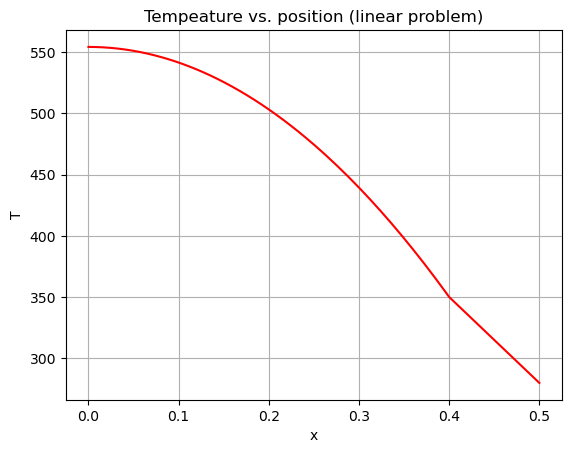

In [29]:
T_dir = 280

k0_   = np.array([  1.37142857,  2.])
k1_   = np.array([  0.         ,  0.])
qext_ = np.array([3500., 50.])
dx_   = np.array([  0.4, 0.1])
print(k0_)
print(k1_)


n_ref = 100
x, dx, cell2mat = create_slab_mesh(n_ref,dx_)

Alist, Abc = build_matrix_per_zone(k0_, dx, cell2mat)
rhslist, rhsbc = build_rhs_per_zone(qext_,T_dir, dx, cell2mat)
T_lin_combine = solve_linear_combine(k0_,qext_,Alist,Abc,rhslist,rhsbc)
print('Max T value = ',np.max(T_lin_combine))

plt.figure()
plt.plot(x,T_lin_combine,'r')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Tempeature vs. position (linear problem)')
plt.grid(True)
plt.show()

# Generate snapshots for linear case:
Split into training and testing sets

In [30]:
np.random.seed(123456789)
n_samples = 50

nominal_ = np.expand_dims(np.append(k0_,k1_), axis=1)
print('nominal values of param=',nominal_)
frac = 0.2
samples = np.random.uniform(low=nominal_*(1-frac), high=nominal_*(1+frac),size=(4,n_samples))
# transpose here to have the params as snapshots x nparam
samples = samples.T

n_train = int(0.8*n_samples)
n_test = n_samples - n_train
x_train = samples[:n_train,:]
x_test  = samples[n_train:,:]
print(x_train.shape,x_test.shape)
print(x_train)

nominal values of param= [[1.37142857]
 [2.        ]
 [0.        ]
 [0.        ]]
(40, 4) (10, 4)
[[1.38943983 2.13001071 0.         0.        ]
 [1.39015493 1.96662055 0.         0.        ]
 [1.37666909 1.68790111 0.         0.        ]
 [1.4885837  2.18395013 0.         0.        ]
 [1.23812514 2.22736285 0.         0.        ]
 [1.51004906 1.71303177 0.         0.        ]
 [1.58201372 2.27094955 0.         0.        ]
 [1.18211607 1.92218106 0.         0.        ]
 [1.46498547 1.92513893 0.         0.        ]
 [1.45011849 1.89653305 0.         0.        ]
 [1.49410405 2.33361249 0.         0.        ]
 [1.50787211 1.99254349 0.         0.        ]
 [1.54617457 2.3727907  0.         0.        ]
 [1.15085267 1.65577678 0.         0.        ]
 [1.09909243 1.88963892 0.         0.        ]
 [1.22375842 1.63612797 0.         0.        ]
 [1.10386567 1.86858999 0.         0.        ]
 [1.29108574 1.92574196 0.         0.        ]
 [1.19878298 1.7864857  0.         0.        ]
 [1.53203

## compute training set

In [31]:
Usnap = np.zeros((len(T_lin_combine),n_samples))

for i in range(n_samples):
    k0 = samples[i,:2]
    Usnap[:,i] = solve_linear_combine(k0,qext_,Alist,Abc,rhslist,rhsbc)

### plot some snapshots


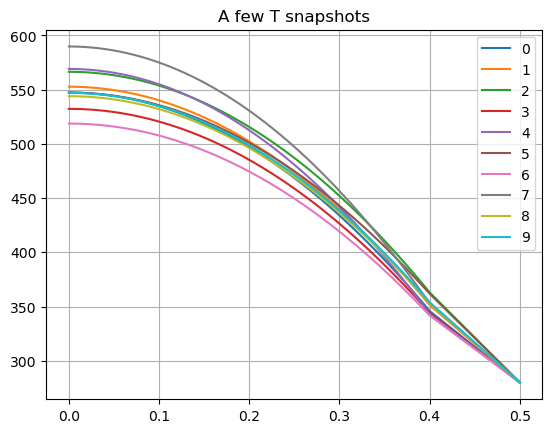

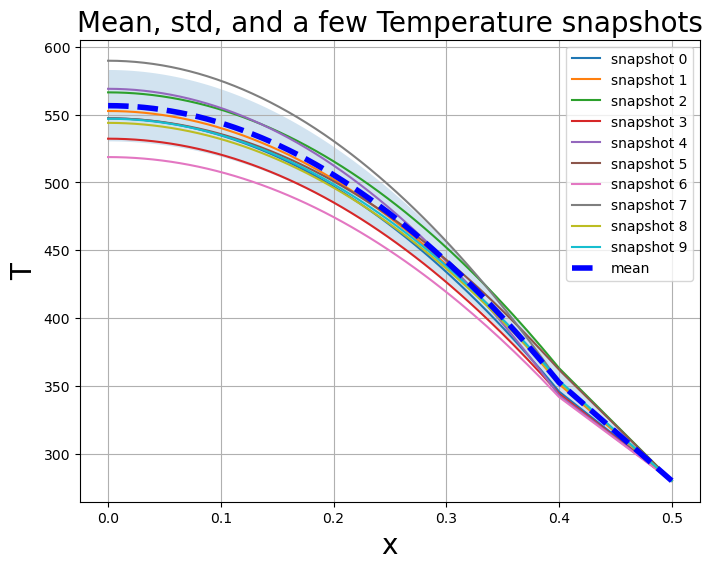

In [32]:
n_samples_plot = min(n_samples,10)
for i in range(n_samples_plot):
    plt.plot(x,Usnap[:,i],label=str(i))
plt.grid(True)
plt.legend()
plt.title('A few T snapshots')
plt.show()

mean_temp = np.mean(Usnap,axis=1)
std_temp  = np.std(Usnap,axis=1)
plt.figure(figsize=(8,6))
for i in range(n_samples_plot):
    plt.plot(x,Usnap[:,i],label='snapshot '+str(i))
plt.plot(x,mean_temp,'b--', linewidth=4, label='mean')
plt.fill_between(x,mean_temp-std_temp,mean_temp+std_temp,alpha=.2)
plt.grid(True)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.legend()
plt.title('Mean, std, and a few Temperature snapshots',fontsize=20)
plt.show()

# SVD
Data matrix $D_T$ is the training set of solution snapshots.

Perform 
$$ D_T = U_T \Sigma_T V_T^t $$

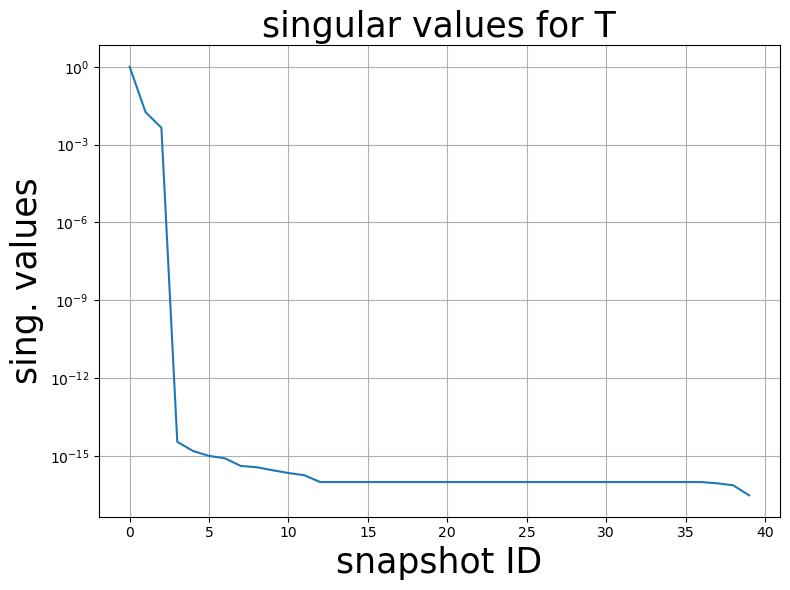

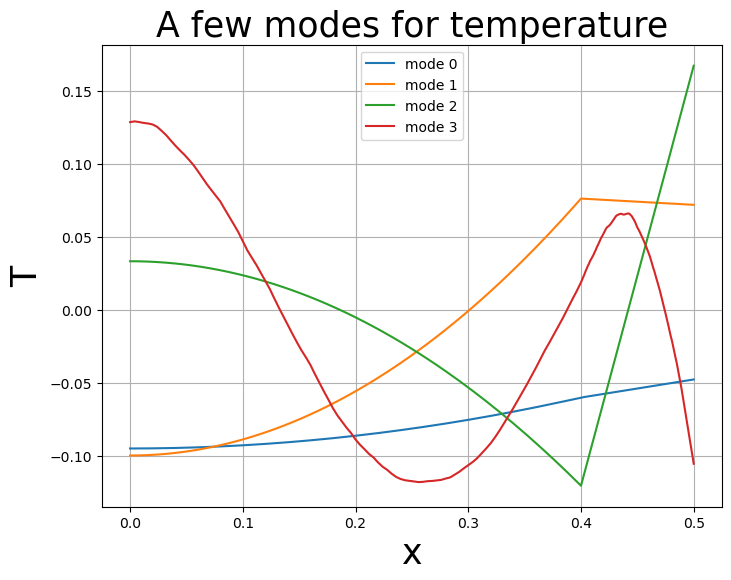

In [33]:
U_all, S, _ = np.linalg.svd(Usnap[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(S/np.max(S))
plt.xlabel('snapshot ID',fontsize=25)
plt.ylabel('sing. values',fontsize=25)
plt.title('singular values for T',fontsize=25)
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()

plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for temperature',fontsize=25)
plt.xlabel('x',fontsize=25)
plt.ylabel('T',fontsize=25)
plt.show()

## Select rank

In [34]:
rU = 3
U = U_all[:,:rU]
print(U.shape)

(201, 3)


# Create intrusive ROM
We use affine decomposition here. Thus, the original system of equations (without the nonlinear term) is (matrix size $N\times N$)
$$ A(\mu) T^{\mu} = b(\mu)$$
It gets Galerkin-projected into
$$ U_T^tA(\mu) U_T c^{\mu} = U_T^tb(\mu)$$
where we used the fact that the new solution is sought as
$$ T^{\mu} = U_T c^{\mu} = \sum_{i=1}^{i=r} u_i c_i^{\mu}$$
with $u_i$ the global basis (vectors of same length as the $T$ vector) and $c_i^{\mu}$ the expansion coefficients that depend on the new parameter $\mu$. $r$ is the rank retained in our approximation.


Note that the above projected system is a system of much smaller size (matrix size $r\times r$)
$$ A_r(\mu) c^{\mu} = b_r(\mu)$$
with
$$ A_r(\mu) = U_T^tA(\mu) U_T \qquad b_r(\mu)= U_T^tb(\mu)$$

Reconstruction part: once the $r$ coefficients $c_i^{\mu}$ ($1\le i \le r$) are obtained, the full-length solution is given by $ T^{\mu} = U_T c^{\mu}$

# Compute the reduced operators for the affine decomposition approach (linear operator and rhs only)

In [35]:
Ar_bc = U.T @ Abc @ U
# u_last= U[-1,:]
# Ar_bc = np.outer(u_last, u_last)

Ar_list = []
for imat in range(len(k1_)):
    Ar_list.append( U.T @ Alist[imat] @ U )

qr_bc = U.T @ rhsbc
qr_list = []
for isrc in range(len(qext_)):
    qr_list.append( U.T @ rhslist[isrc] )

# Build and solve linear ROM

coefficients =  [-6035.41207631  -194.55807206    39.79362967]


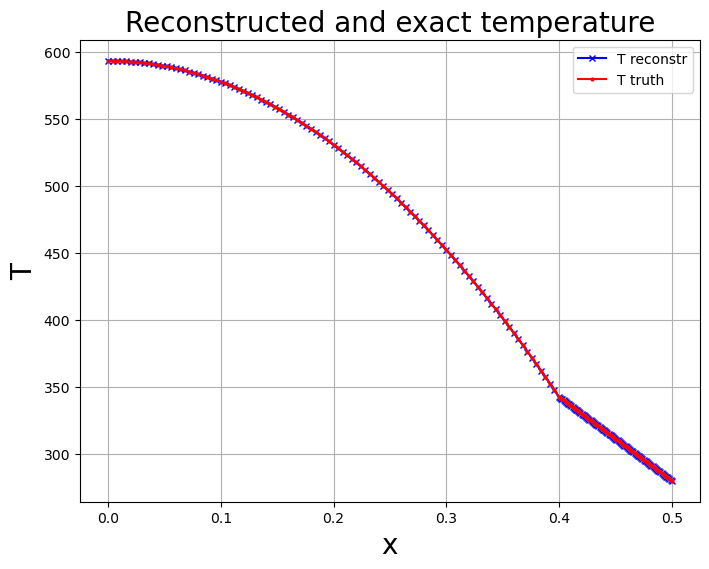

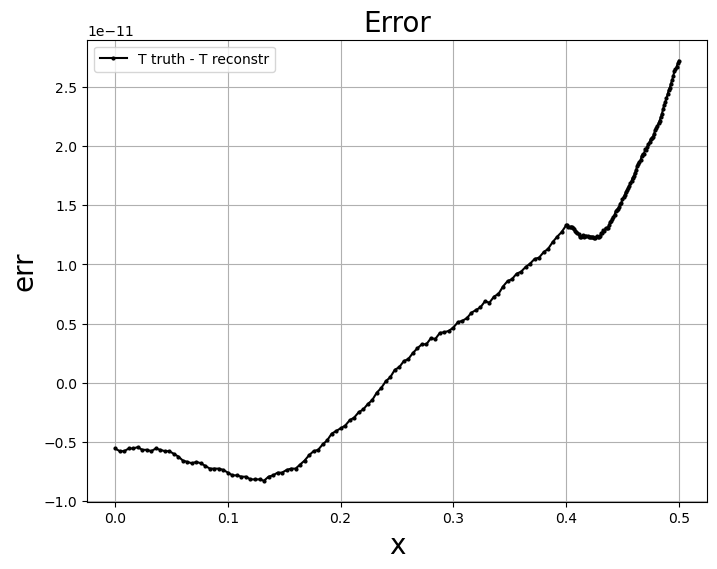

In [36]:
my_sample=45
k0, k1 = samples[my_sample,:2], samples[my_sample,2:]

Ar = combine_matrix_per_zone(k0,Ar_list,Ar_bc)
qr = combine_rhs_per_zone(qext_,qr_list,qr_bc)
   
# solve
c_lin = np.linalg.solve(Ar,qr)
T_rec = U@c_lin
T_truth = Usnap[:,my_sample]

print('coefficients = ',c_lin)
plt.figure(figsize=(8,6))
plt.plot(x,T_rec,'-xb',ms=4,label='T reconstr')
plt.plot(x,T_truth,'-or',ms=2,label='T truth')
plt.grid(True)
plt.legend()
plt.title('Reconstructed and exact temperature',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x,T_truth-T_rec,'-ok',ms=2,label='T truth - T reconstr')
plt.grid(True)
plt.legend()
plt.title('Error',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('err',fontsize=20)
plt.show()

# Now, the nonlinear part of the problem

We solve
$$ -\frac{d}{dx} (k^0(x) + k^1(x) T)\frac{dT}{dx} = q(x)
$$

After finite-difference discretization, we obtain a full-order nonlinear system that we write as

$$
A(\mu)T(\mu) + F(T(\mu)) = b(\mu)
$$


| Zone ID | $x$   | $$\begin{equation}k^0\end{equation}$$  | $\begin{equation}k^1\end{equation}$ | $q$ |
| :---    | :---: | ---:  | ---:  | --- |
| I  | $$\begin{equation}x \in [0.0, 0.4]\end{equation}$$ | 1.37142857  | -0.00057143 | 3500. |  
| II | $$\begin{equation}x \in [0.4, 0.5]\end{equation}$$ | 2.          | 0.          |   50. |



In [37]:
k1_   = np.array([ -0.00057143 ,  0.])

# Routines that build non-linear system and solves it for $T$


In [38]:
def build_nonlinear_term(T,k1_,cell2mat,dx):
    # make mat property per cell
    T_ave = (T[:-1] + T[1:])/2
    k1 = k1_[cell2mat]
    cond = k1*T_ave

    # number of points
    n_pts = len(dx) + 1
    
    # create indices for rows and columns of the tridiagonal stiffness matrix
    indr = np.kron(np.arange(0,n_pts),np.ones(3))
    indr = indr[1:-1]

    indc = np.zeros((n_pts,3))
    indc[0,:] = np.array([-1,0,1],dtype=int)
    for i in range (1,n_pts):
        indc[i,:] = indc[i-1,:]+1
    indc = indc.flatten()
    indc = indc[1:-1]
    
    # matrix
    L = np.zeros(n_pts)
    L[1:] = -cond/dx
    R = np.zeros(n_pts)
    R[:-1] = -cond/dx
    D = np.zeros(n_pts)
    D[:-1] += -R[:-1]
    D[1:]  += -L[1:]  
    arr = np.vstack((L,D,R)).T.flatten()[1:-1]
    K = sparse.csr_matrix( (arr, (indr, indc)), shape=(n_pts, n_pts) )
    # apply right bc (Dirichlet)
    K[-1,-2:]=0
    
    return K@T

In [39]:
from scipy.optimize import fsolve

def solve_nonlinear(k0_,k1_,qext_,K_list,K_bc,rhs_list,rhs_bc,dx,cell2mat,T_init):  

    A1 = combine_matrix_per_zone(k0_,K_list,K_bc)
    rhs = combine_rhs_per_zone(qext_,rhs_list,rhs_bc)

    F = lambda x: build_nonlinear_term(x, k1_, cell2mat, dx)

    f = lambda x: A1@x + F(x) - rhs

    # make sure the initial guess satisfies the Dirichlet BC
    T_init[-1] = T_dir
    # solve
    T  = fsolve(f, T_init)
    
    return T

## solve and plot

Max T value =  605.0106108788045


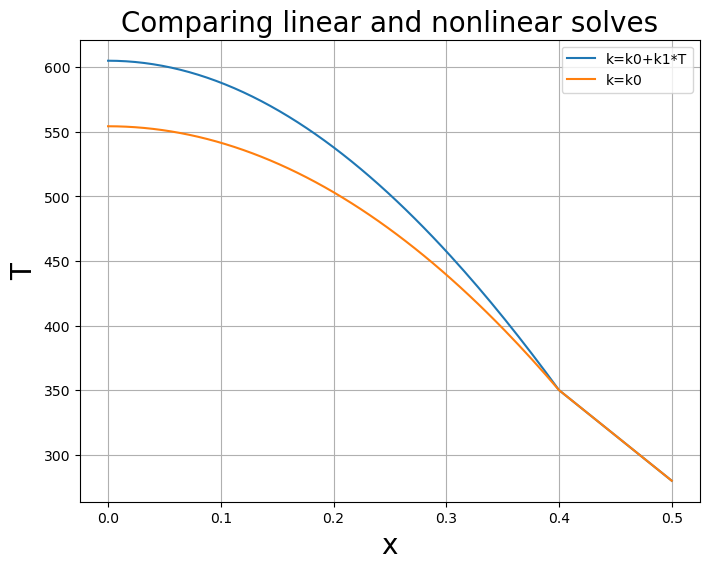

In [40]:
T_init = np.zeros(len(x))
T = solve_nonlinear(k0_,k1_,qext_,Alist, Abc, rhslist, rhsbc, dx, cell2mat,T_init)
print('Max T value = ',np.max(T))

plt.figure(figsize=(8,6))
plt.plot(x,T, label='k=k0+k1*T')

T_lin = solve_linear_combine(k0_,qext_,Alist,Abc,rhslist,rhsbc)
plt.plot(x,T_lin, label='k=k0')

plt.grid(True)
plt.legend()
plt.title('Comparing linear and nonlinear solves',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.show()

# generate snapshots

In [41]:
np.random.seed(123456789)
n_samples = 50

# mean_ = np.expand_dims(np.append(k0_,k1_)        ,axis=1)
# std_  = np.expand_dims(np.append(k0_*0.2,k1_*0.15),axis=1)
# samples = np.random.normal(loc=mean_,scale=std_,size=(4,n_samples))
nominal_ = np.expand_dims(np.append(k0_,k1_), axis=1)
print('nominal values of param=',nominal_)
frac = 0.2
samples = np.random.uniform(low=nominal_*(1-frac), high=nominal_*(1+frac),size=(4,n_samples))
# transpose here to have the params as snapshots x nparam
samples = samples.T

n_train = int(0.8*n_samples)
n_test = n_samples - n_train
x_train = samples[:n_train,:]
x_test  = samples[n_train:,:]
print(x_train.shape,x_test.shape)
print(x_train)

nominal values of param= [[ 1.37142857e+00]
 [ 2.00000000e+00]
 [-5.71430000e-04]
 [ 0.00000000e+00]]
(40, 4) (10, 4)
[[ 1.38943983e+00  2.13001071e+00 -6.20012492e-04  0.00000000e+00]
 [ 1.39015493e+00  1.96662055e+00 -4.95330179e-04  0.00000000e+00]
 [ 1.37666909e+00  1.68790111e+00 -5.14044635e-04  0.00000000e+00]
 [ 1.48858370e+00  2.18395013e+00 -6.47811561e-04  0.00000000e+00]
 [ 1.23812514e+00  2.22736285e+00 -6.42994629e-04  0.00000000e+00]
 [ 1.51004906e+00  1.71303177e+00 -5.63691800e-04  0.00000000e+00]
 [ 1.58201372e+00  2.27094955e+00 -5.82396282e-04  0.00000000e+00]
 [ 1.18211607e+00  1.92218106e+00 -6.13353052e-04  0.00000000e+00]
 [ 1.46498547e+00  1.92513893e+00 -5.69842947e-04  0.00000000e+00]
 [ 1.45011849e+00  1.89653305e+00 -6.19124141e-04  0.00000000e+00]
 [ 1.49410405e+00  2.33361249e+00 -6.17969516e-04  0.00000000e+00]
 [ 1.50787211e+00  1.99254349e+00 -5.57212161e-04  0.00000000e+00]
 [ 1.54617457e+00  2.37279070e+00 -5.03615198e-04  0.00000000e+00]
 [ 1.150852

## compute training set

In [42]:
Usnap = np.zeros((len(T),n_samples))
Fsnap = np.zeros((len(T),n_samples))

for i in range(n_samples):
    k0, k1 = samples[i,:2], samples[i,2:]
    Usnap[:,i] = solve_nonlinear(k0,k1,qext_,Alist, Abc, rhslist, rhsbc, dx, cell2mat,T_init)
    Fsnap[:,i] = build_nonlinear_term(Usnap[:,i],k1,cell2mat,dx)

In [73]:
Fsnap[-1,49]

0.0

### plot some snapshots


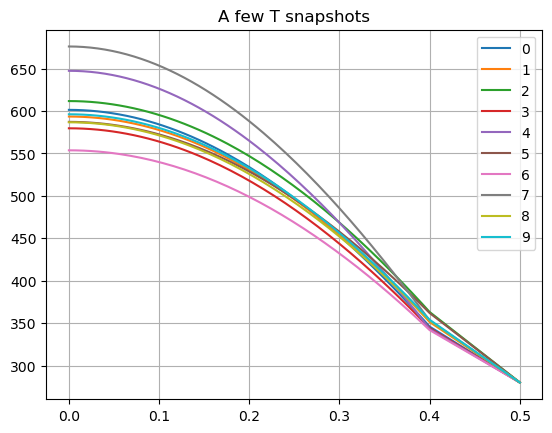

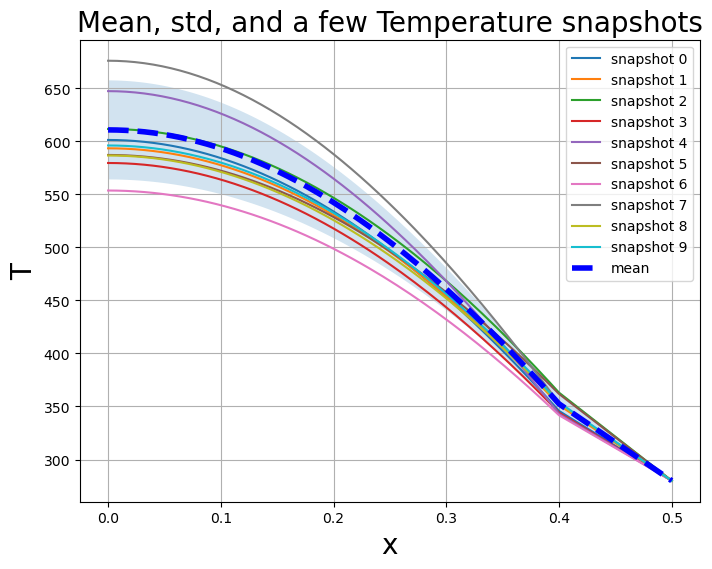

In [43]:
n_samples_plot = min(n_samples,10)
for i in range(n_samples_plot):
    plt.plot(x,Usnap[:,i],label=str(i))
plt.grid(True)
plt.legend()
plt.title('A few T snapshots')
plt.show()

mean_temp = np.mean(Usnap,axis=1)
std_temp  = np.std(Usnap,axis=1)
plt.figure(figsize=(8,6))
for i in range(n_samples_plot):
    plt.plot(x,Usnap[:,i],label='snapshot '+str(i))
plt.plot(x,mean_temp,'b--', linewidth=4, label='mean')
plt.fill_between(x,mean_temp-std_temp,mean_temp+std_temp,alpha=.2)
plt.grid(True)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.legend()
plt.title('Mean, std, and a few Temperature snapshots',fontsize=20)
plt.show()

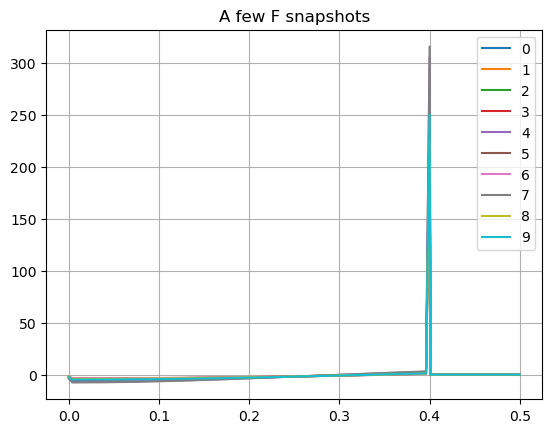

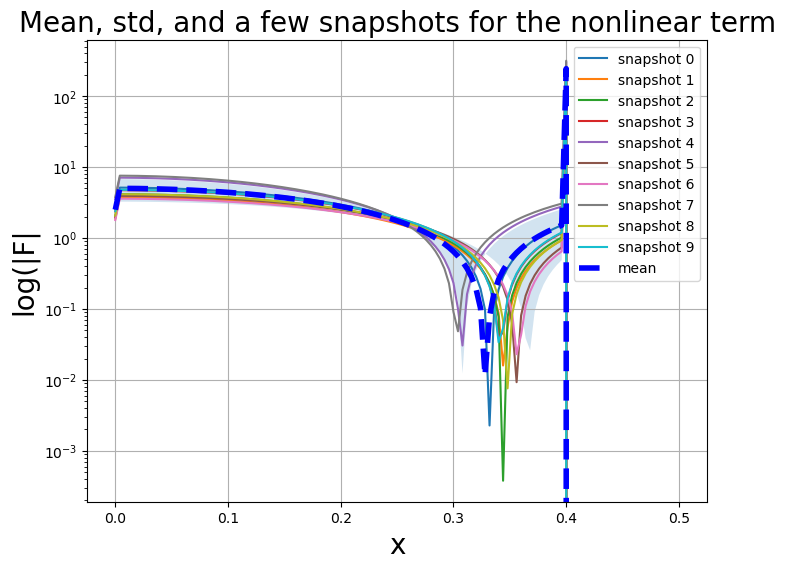

In [59]:
n_samples_plot = min(n_samples,10)
for i in range(n_samples_plot):
    plt.plot(x,Fsnap[:,i],label=str(i))
plt.grid(True)
plt.legend()
plt.title('A few F snapshots')
plt.show()

mean_temp = np.mean(Fsnap,axis=1)
std_temp  = np.std(Fsnap,axis=1)
plt.figure(figsize=(8,6))
for i in range(n_samples_plot):
    plt.semilogy(x,np.abs(Fsnap[:,i]),label='snapshot '+str(i))
plt.semilogy(x,np.abs(mean_temp),'b--', linewidth=4, label='mean')
plt.fill_between(x,np.abs(mean_temp-std_temp),np.abs(mean_temp+std_temp),alpha=.2)
plt.grid(True)
plt.legend()
plt.xlabel('x',fontsize=20)
plt.ylabel('log(|F|',fontsize=20)
plt.legend()
plt.title('Mean, std, and a few snapshots for the nonlinear term',fontsize=20)
plt.show()

# SVD
Data matrix $D_T$ is the training set of solution snapshots.

Perform 
$$ D_T = U_T \Sigma_T V_T^t $$

Data matrix $D_F$ is the training set of nonlinear term snapshots.

Perform 
$$ D_F = U_F \Sigma_F V_F^t $$

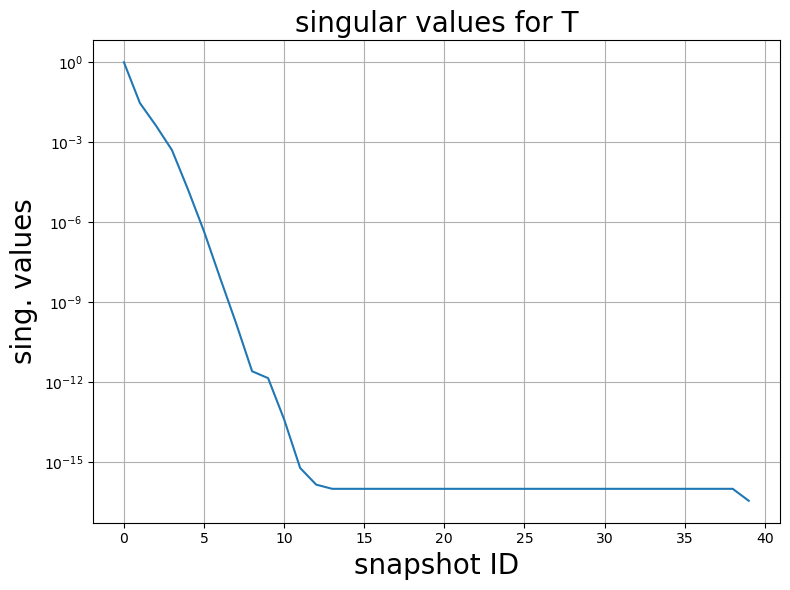

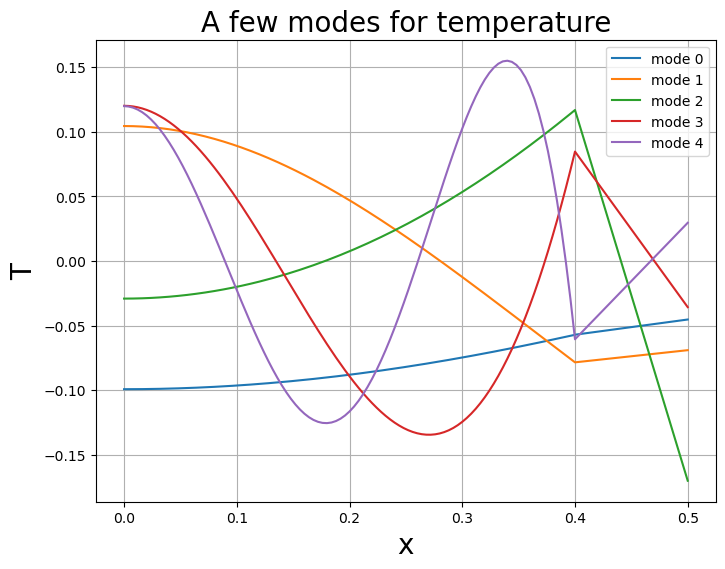

In [45]:
U_all, S, _ = np.linalg.svd(Usnap[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(S/np.max(S))
plt.xlabel('snapshot ID',fontsize=20)
plt.ylabel('sing. values',fontsize=20)
plt.title('singular values for T',fontsize=20)
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for temperature',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.show()

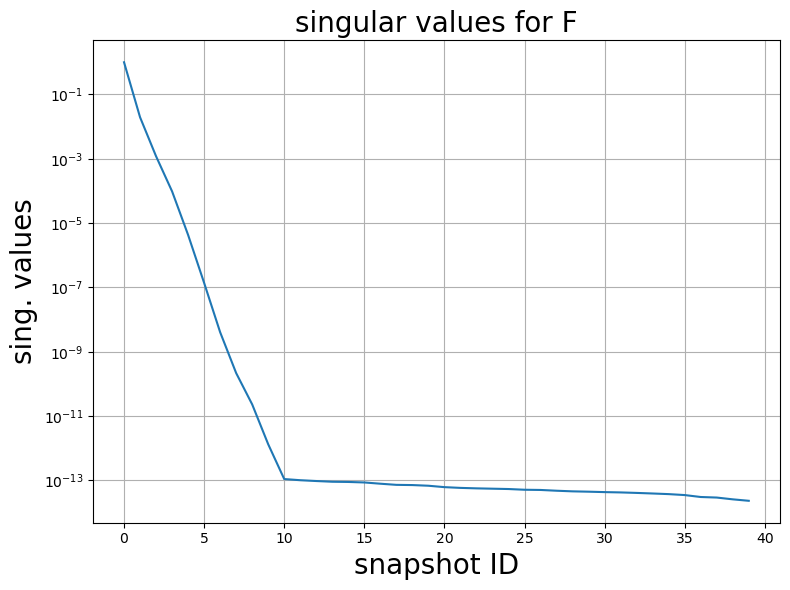

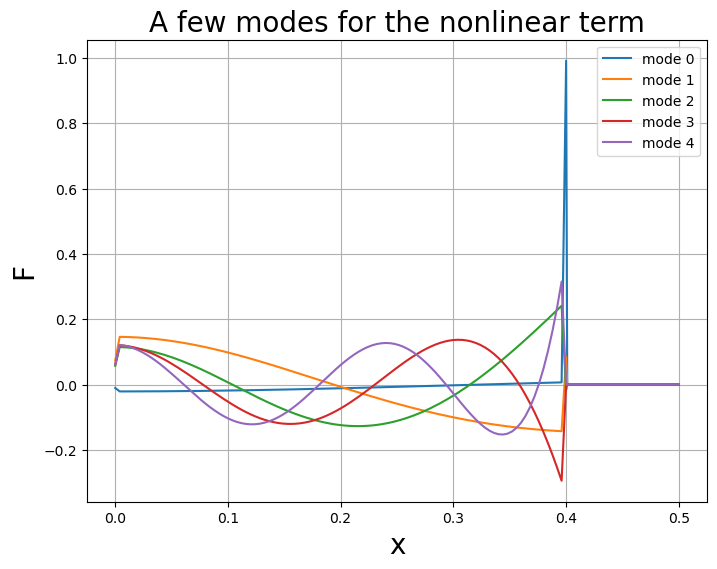

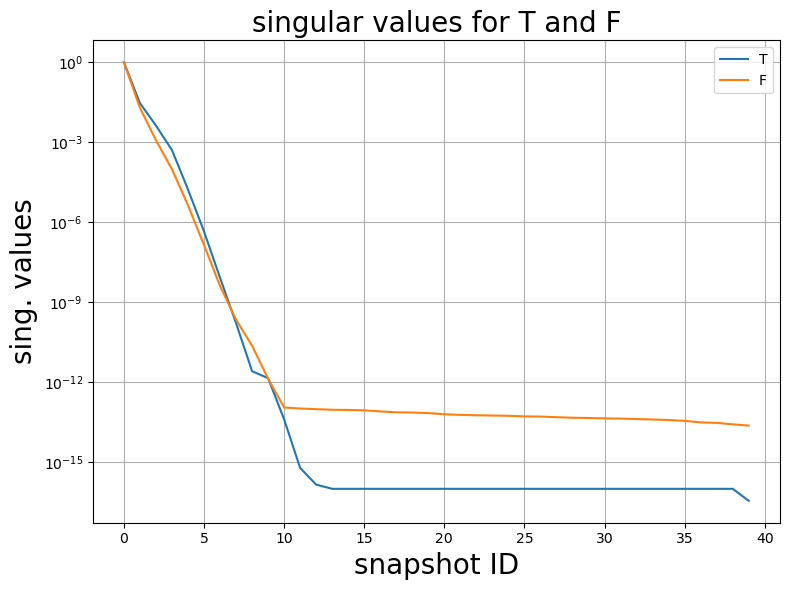

In [46]:
V_all, SF, _ = np.linalg.svd(Fsnap[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(8,6))
plt.semilogy(SF/np.max(SF))
plt.xlabel('snapshot ID',fontsize=20)
plt.ylabel('sing. values',fontsize=20)
plt.title('singular values for F',fontsize=20)
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(x,V_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for the nonlinear term',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('F',fontsize=20)
plt.show()

plt.figure(figsize=(8,6))
plt.semilogy(S /np.max(S ),label='T')
plt.semilogy(SF/np.max(SF),label='F')
plt.xlabel('snapshot ID',fontsize=20)
plt.ylabel('sing. values',fontsize=20)
plt.title('singular values for T and F',fontsize=20)
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig('sv_Ntrain' + str(n_train) + '.pdf') 
plt.show()


## select ranks

In [47]:
rU = 4
rF = 2
U = U_all[:,:rU]
V = V_all[:,:rF]
print(U.shape)
print(V.shape)

(201, 4)
(201, 2)


# create intrusive ROM (linear part)
We use affine decomposition here. Thus, the original system of equations (without the nonlinear term) is (matrix size $N\times N$)
$$ A(\mu) T^{\mu} = b(\mu)$$
It gets Galerkin-projected into
$$ U_T^tA(\mu) U_T c^{\mu} = U_T^tb(\mu)$$
where we used the fact that the new solution is sought as
$$ T^{\mu} = U_T c^{\mu} = \sum_{i=1}^{i=r} u_i c_i^{\mu}$$
with $u_i$ the global basis (vectors of same length as the $T$ vector) and $c_i^{\mu}$ the expansion coefficients that depend on the new parameter $\mu$. $r$ is the rank retained in our approximation.


Note that the above projected system is a system of much smaller size (matrix size $r\times r$)
$$ A_r(\mu) c^{\mu} = b_r(\mu)$$
with
$$ A_r(\mu) = U_T^tA(\mu) U_T \qquad b_r(\mu)= U_T^tb(\mu)$$

Reconstruction part: once the $r$ coefficients $c_i^{\mu}$ ($1\le i \le r$) are obtained, the full-length solution is given by $ T^{\mu} = U_T c^{\mu}$

# compute the reduced operators for the affine decomposition approach (linear operator and rhs only)

In [48]:
Ar_bc = U.T @ Abc @ U
# u_last= U[-1,:]
# Ar_bc = np.outer(u_last, u_last)

Ar_list = []
for imat in range(len(k0_)):
    Ar_list.append( U.T @ Alist[imat] @ U )

qr_bc = U.T @ rhsbc
qr_list = []
for isrc in range(len(qext_)):
    qr_list.append( U.T @ rhslist[isrc] )

## DEIM  (nonlinear part)
When a nonlinear term is present, the full-order nonlinear solve is:
$$ A(\mu) T^{\mu} +F(T^{\mu};\mu) - b(\mu) = 0$$

We collect snapshots of $T^{\mu}$ but also of $F(T^{\mu};\mu)$.

We perform an SVD for the temperature snapshots
$$ D_T = U_T \Sigma_T V_T^T $$
and the nonlinear term snapshots
$$ D_F = U_F \Sigma_F V_F^T $$

We Galerkin project the nonlinear system of equations
$$ U_T^tA(\mu) U_T c_T^{\mu} +U_T^t F(U_Tc_T^\mu;\mu)- U_T^tb(\mu) = 0$$

This yields the reduced nonlinear system
$$A_r(\mu) c_T^{\mu} + U_T^t F(U_Tc_T^\mu;\mu)- b_r(\mu) = 0$$
but the nonlinear term still apperently requires a full-order level evaluation.

In DEIM, we compute
$$F(U_Tc_T) \approx U_F (P^t U_F)^{-1} P^t F(U_Tc)$$
- Matrix $M=U_T^t U_F (P^t U_F)^{-1}$ can be computed once for all.
- $P^t F(U_Tc)$ is just a selection of a few rows of $F$ based on the selector matrix $P$.


In [49]:
def DEIM_SVD(u_in):
    [n, r] = np.shape(u_in)
    print(n,r)
    P, list_ind = np.zeros([n,r]), np.zeros(r,dtype=int)
    
    ind = np.argmax(np.abs(u_in[:, 0]))
    
    print('DEIM Cycle: ', 0)
    P[ind,0] = 1
    BB = np.expand_dims(u_in[:,0],axis=1)
    list_ind[0]= ind
    
    for i in range(1,r):
        print('DEIM Cycle: ', i)
        P_loc, u_i = P[:,:i], u_in[:,i]        
        mat = P_loc.T @ BB
        rhs = P_loc.T @ u_i
        c = np.linalg.solve(mat, rhs)
        residual = u_i - BB@c
        ind = np.argmax(np.abs(residual))
        BB = np.hstack((BB, np.expand_dims(u_i,axis=1)))
        P[ind,i] = 1
        list_ind[i] = ind
    print(list_ind)
    phi = np.sort(list_ind[:r]).astype(int)
    P2 = np.zeros([n,r])
    for j,i in enumerate(phi):
        P2[i,j]=1
    
    return P[:,:r],list_ind

In [50]:
P,list_ind = DEIM_SVD(V)

201 2
DEIM Cycle:  0
DEIM Cycle:  1
[100   1]


## precompute matrix for DEIM once for all:

In [51]:
M = U.T @ V @ np.linalg.inv(P.T@V)
print(M.shape)

(4, 2)


### DEIM residual

Here, for index $i$, we just need to retrieve the $i$-th row of $F$ (let's call it $F_i$). We only need to evaluate the nonlinear residual there because this is what the selector matrix $P$ is actually doing, so **no full-order** complexity operations (only very local portions of the nonlinear residual are needed)

Any row $F_i$ depends on the latest nonlinear estimate of temperature at nodes $i-1$, $i$, and $i+1$. 

This is a simple finite difference of the term $-\frac{d}{dx}k^1 T\frac{dT}{dx}$

Or,
$$
-\delta _{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
\delta _{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
$$
where $T$ is actually $Uc$ and $\delta _{i+1/2} = k^1_{i+1/2} T_{i+1/2} $

In [52]:
def deim_res(c,k1_,cell2mat,list_ind,U):
    
    n_pts, r = U.shape
    out = np.zeros(len(list_ind))

    for i in range(len(list_ind)):
        
        if list_ind[i]==n_pts-1: # on the boundary node
            out[i] = 0
        
        elif list_ind[i]==0: # on the symmetry node
            gn = [0,1]
            Uc = U[gn,:] @ c           # (2xr) x (rx1) = (2x1)

            Uc_rite = np.mean(Uc)
            k1_rite = k1_[cell2mat[0]]
            cond_rite = k1_rite*Uc_rite
            oper = cond_rite/dx[0] * np.array([-1., 1.])
            
            out[i] = oper @ Uc  # (1x2) x (2x1)
        
        else: # all other nodes
            gn = list_ind[i] + [-1, 0, 1]
            Uc = U[gn,:]@c                      # (3xr) x (rx1) = (3x1)
            
            Uc_rite = np.mean(Uc[1:])
            cell_id = list_ind[i] 
            k1_rite = k1_[cell2mat[cell_id]]
            cond_rite = k1_rite*Uc_rite
            oper = -cond_rite/dx[cell_id] * np.array([0, -1., 1.])

            Uc_left = np.mean(Uc[:2])
            cell_id = list_ind[i] - 1
            k1_left = k1_[cell2mat[cell_id]]
            cond_left = k1_left*Uc_left

            oper += cond_left/dx[cell_id] * np.array([-1., 1., 0.])

            out[i] = oper @ Uc  # (1x3) x (3x1)

    return out

## Testing point not in training set

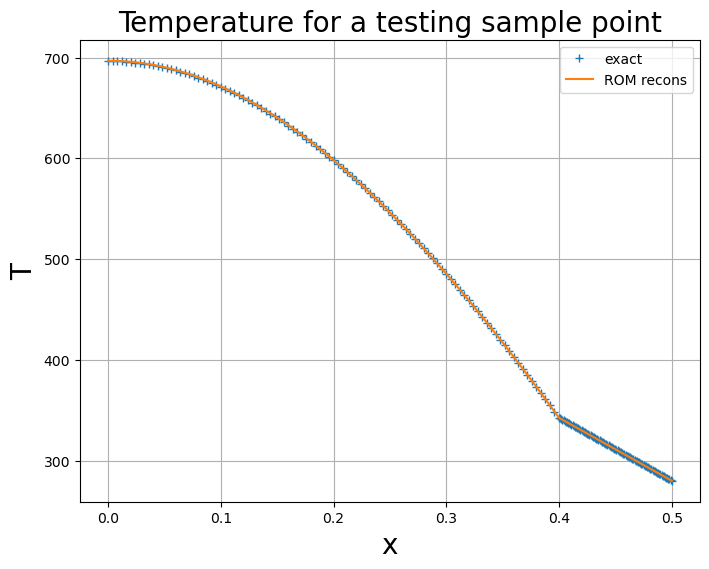

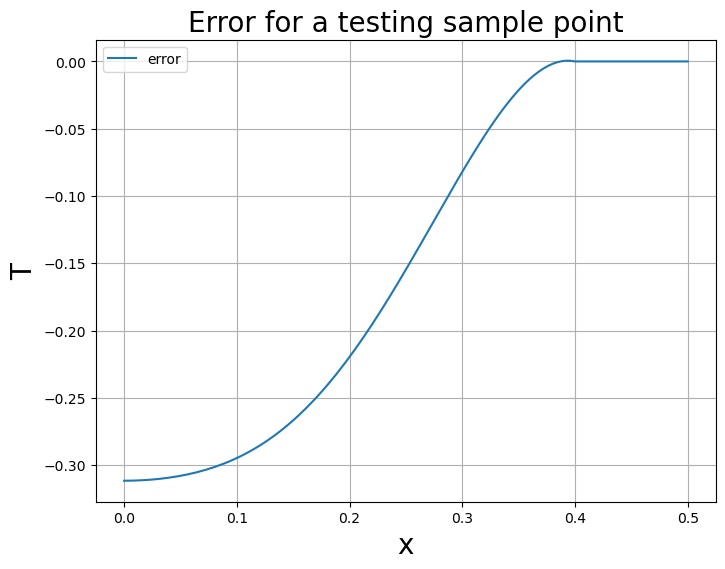

In [53]:
my_sample=45
k0, k1 = samples[my_sample,:2], samples[my_sample,2:]

Ar = combine_matrix_per_zone(k0,Ar_list,Ar_bc)
qr = combine_rhs_per_zone(qext_,qr_list,qr_bc)
   
fr = lambda c: Ar@c + M@deim_res(c,k1,cell2mat,list_ind,U) - qr
# solve
c_init = np.linalg.solve(Ar,qr)
c  = fsolve(fr, c_init)

plt.figure(figsize=(8,6))
plt.plot(x,Usnap[:,my_sample],'+',label='exact')
plt.plot(x,U@c,label='ROM recons')
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.title('Temperature for a testing sample point',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x,Usnap[:,my_sample]-U@c,label='error')
plt.xlabel('x',fontsize=20)
plt.ylabel('T',fontsize=20)
plt.title('Error for a testing sample point',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

## what's happening in DEIM ?
**INPUT**: basics vectors $V$ for nonlinear term

**OUTPUT**: set of mesh indices where the nonlinear term need to be evaluated

1. Pick first basis vector $v_1$. Get index $i_1$ where $|v_1|$ is largest. 
2. Set $W=[v_1]$. Set $P=[i_1]$
3. For k=2 to $r_F$ do
4. $\qquad$  Solve $P^t W c = P^t v_k$  (extract rows and find best linear representation)
5. $\qquad$  Compute residual $res = v_k - Wc$
6. $\qquad$  Get index $i_k$ where $|res|$ is largest.
7. $\qquad$  Set $W\leftarrow[W,v_k]$. Set $P\leftarrow[P,i_k]$
8. End for

201 2
DEIM Cycle:  0
DEIM Cycle:  1
[100   1]


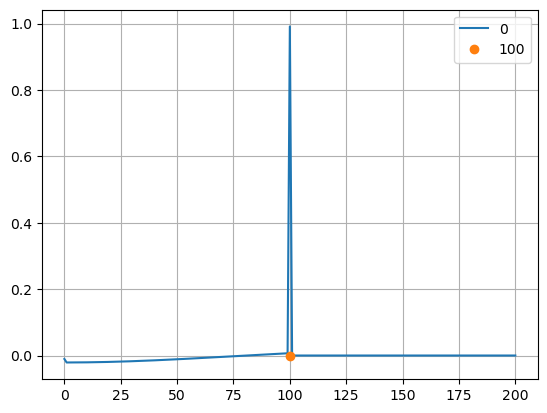

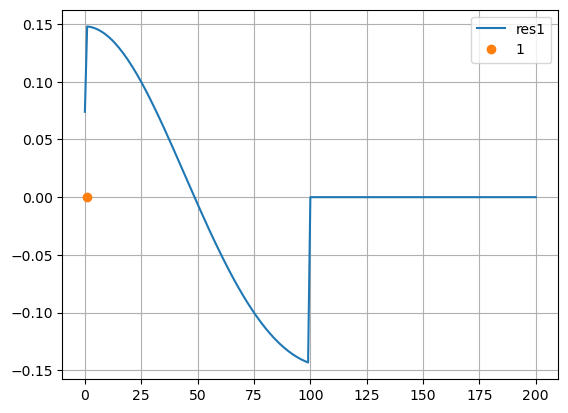

In [54]:
def DEIM_SVD_plot(u_in):
    [n, r] = np.shape(u_in)
    print(n,r)
    P, list_ind = np.zeros([n,r]), np.zeros(r,dtype=int)
    
    ind = np.argmax(np.abs(u_in[:, 0]))
    
    print('DEIM Cycle: ', 0)
    P[ind,0] = 1
    BB = np.expand_dims(u_in[:,0],axis=1)
    list_ind[0]= ind

    plt.figure()
    plt.plot(BB[:,0],label=str(0))
    plt.plot(ind,0,'o',label=str(ind))
    plt.grid(True)
    plt.legend()
    
    for i in range(1,r):
        print('DEIM Cycle: ', i)
        P_loc, u_i = P[:,:i], u_in[:,i]        
        mat = P_loc.T @ BB
        rhs = P_loc.T @ u_i
        c = np.linalg.solve(mat, rhs)
        residual = u_i - BB@c
        ind = np.argmax(np.abs(residual))
        
        plt.figure()
        plt.plot(residual,label='res'+str(i))
        plt.plot(ind,0,'o',label=str(ind))
        plt.grid(True)
        plt.legend()
        
        BB = np.hstack((BB, np.expand_dims(u_i,axis=1)))
        P[ind,i] = 1
        list_ind[i] = ind
    print(list_ind)

DEIM_SVD_plot(V)

# demistifying DEIM
In DEIM, we compute
$$F(U_Tc_T) \approx U_F (P^t U_F)^{-1} P^t F(U_Tc)$$
- Matrix $M=U_T^t U_F (P^t U_F)^{-1}$ can be computed once for all.
- $P^t F(U_Tc)$ is just a selection of a few rows of $F$ based on the selector matrix $P$.


We can view the approximation as
$$F(U_Tc_T) = U_F c_F$$
Thus the $c_F$ vector is
$$c_F = U_F^t F(U_Tc_T) = U_F^t U_F (P^t U_F)^{-1} P^t F(U_Tc)$$

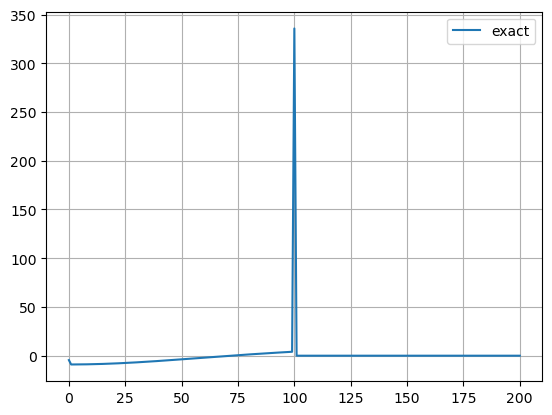

(2, 2)


In [55]:
plt.figure()
plt.plot(Fsnap[:,my_sample],'-',label='exact')
plt.grid(True)
plt.legend()
plt.show()

MM =  np.linalg.inv(P.T@V)
print(MM.shape)

c for T [-6.61102702e+03  3.76473991e+02 -4.35415902e+01  6.33578845e+00]
c for F: [339.51116857 -12.83296852]


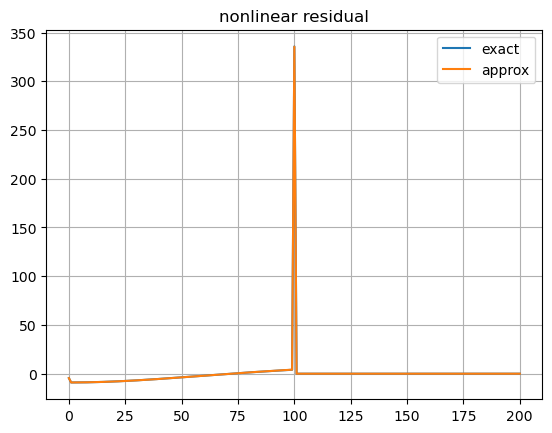

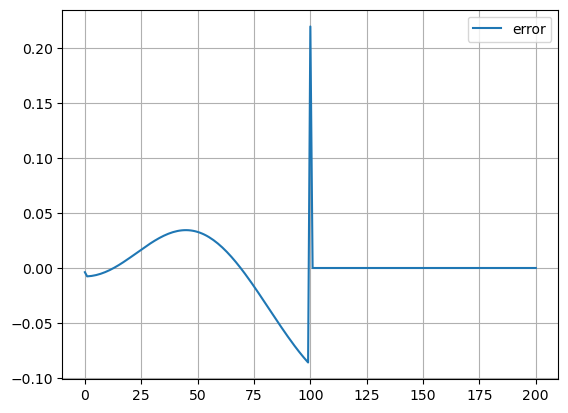

In [56]:
# snapshot temperature
T = Usnap[:,my_sample]
# associated expansion coefficients for T
c_T = U.T @ T
print('c for T',c_T)

# nonlinear residual at 'magic' points
PtF = deim_res(c_T,k1,cell2mat,list_ind,U)
# print(PtF)
# print(PtF.shape)
# making up expansion coefficients for F
c_F = MM @ PtF
print('c for F:',c_F)

Fapprox = V @ c_F
plt.figure()
plt.plot(Fsnap[:,my_sample],'-',label='exact')
plt.plot(Fapprox,'-',label='approx')
plt.grid(True)
plt.title('nonlinear residual')
plt.legend()
plt.show()

plt.figure()
plt.plot(Fsnap[:,my_sample]-Fapprox,'-',label='error')
plt.grid(True)
plt.legend()
plt.show()

In [57]:
# for i in range(rF):
#     plt.figure()
#     plt.plot(V[:,i],'-',label=str(list_ind[i]))
#     plt.plot(np.array(list_ind[:i+1],dtype=float),np.zeros(i+1),'o')
#     plt.grid(True)
#     plt.legend()
# plt.show()

# for i in range(rF):
#     plt.figure()
#     Fapprox = V[:,:i+1] @ c_F[:i+1]
#     lab = 'Fapprox '+str(i)+' ind='+str(list_ind[i])
#     plt.plot(Fapprox-Fsnap[:,my_sample],'-',label=lab)
#     plt.plot(np.array(list_ind[:i+1],dtype=float),np.zeros(i+1),'o')
#     plt.grid(True)
#     plt.legend()
# plt.show()